In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
# from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/all')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [7]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
workers=7
random_crop=True
pseudo_label=False
val_folder = 'sample_test_sync'
# val_folder = 'val'
S_PREFIX = '38-wide-crop-eval'

In [8]:
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

### Create dataloader

In [9]:
class MatchedFilesDataset(Dataset):
    def __init__(self, fnames, y, tfms, path):
        self.path,self.fnames = path,fnames
        self.open_fn = pil_loader
        self.y=y
        self.open_y_fn = pil_loader
        assert(len(fnames)==len(y))
        
        self.n = self.get_n()
        self.c = self.get_c()
        self.tfms = tfms
        
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): return self.open_y_fn(os.path.join(self.path, self.y[i]))
    def get_n(self): return len(self.fnames)
    def get_c(self): return 2
    
    def get(self, tfms, x, y):
        for fn in tfms:
            #pdb.set_trace()
            x, y = fn(x, y)
        return (x, y)
    
    def __getitem__(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.tfms, x, y)
    
    def __len__(self): return self.n

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

In [10]:

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [11]:
def crop_bg_pil(x,y):
    w, h = x.size
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    pad_right=32-w%32
    if pad_right == 32: pad_right = 0
    return TTF.crop(x, top, 0, bot-top, w+pad_right), TTF.crop(y, top, 0, bot-top, w+pad_right)

In [12]:
class RHF(object):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x, y):
        if random.random() < self.p:
            return TTF.hflip(x), TTF.hflip(y)
        return x,y

In [13]:
class RR(object):
    def __init__(self, degrees=2): self.degrees = degrees
    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return TTF.rotate(x, angle), TTF.rotate(y, angle)

In [14]:
def tfm_x_wrapper(tfm):
    return lambda x,y: (tfm(x), y)

In [15]:
class RC():
    def __init__(self, targ_sz):
        self.targ_sz = targ_sz

    def __call__(self, x, y):
        rand_w = random.uniform(0, 1)
        rand_h = random.uniform(0, 1)
        w,h = x.size
        t_w,t_h = self.targ_sz
        start_x = np.floor(rand_w*(w-t_w)).astype(int)
        start_y = np.floor(rand_h*(h-t_h)).astype(int)
        return TTF.crop(x, start_y, start_x, t_h, t_w), TTF.crop(y, start_y, start_x, t_h, t_w)

In [16]:
def convert_y(y_img):
    yr = (y_img==ROADS) | (y_img==ROAD_LINES)
    yc = (y_img==VEHICLES)
    cutoff_y = int(yc.shape[0]*.875)
    yc[cutoff_y:,:] = 0
    rn = ~(yr | yc)
    return torch.from_numpy(np.stack((rn,yc,yr)).astype(int))

def xy_tensor(x,y):
    y_img = np.array(y, np.int32, copy=False)
    return TTF.to_tensor(x), convert_y(y_img[:,:,0])

In [17]:
class RRC(transforms.RandomResizedCrop):
    def __call__(self, x, y):
        i, j, h, w = self.get_params(x, self.scale, self.ratio)
        x = TTF.resized_crop(x, i, j, h, w, self.size, self.interpolation)
        y = TTF.resized_crop(y, i, j, h, w, self.size, self.interpolation)
        return x, y

In [18]:
def torch_loader(f_ext, data_path, bs, size, workers=7, random_crop=False, pseudo_label=False, val_folder=None):
    # Data loading code
    x_names = np.sort(np.array(glob(str(data_path/f'CameraRGB{f_ext}'/'*.png'))))
    y_names = np.sort(np.array(glob(str(data_path/f'CameraSeg{f_ext}'/'*.png'))))

    x_n = x_names.shape[0]
    val_idxs = list(range(x_n-300, x_n))
    
    if pseudo_label:
        x_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraRGB{f_ext}/*.png')))
        y_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraSeg{f_ext}/*.png')))
        x_names = np.concatenate((x_names, x_names_test))
        x_names = np.concatenate((y_names, y_names_test))
        print(f'Pseudo-Labels: {len(x_names_test)}')
    if val_folder:
        x_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraRGB{f_ext}/*.png')))
        y_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraSeg{f_ext}/*.png')))
        val_x,val_y = x_names_val, y_names_val
        trn_x,trn_y = x_names, y_names
        print(f'Val Labels:', len(val_x))
    else:
        ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    print(f'Val x:{len(val_x)}, y:{len(val_y)}')
    print(f'Trn x:{len(trn_x)}, y:{len(trn_y)}')
    print(f'All x:{len(x_names)}')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    train_tfms = [
        crop_bg_pil,
        tfm_x_wrapper(transforms.ColorJitter(.2,.2,.2)),
#         tfm_x_wrapper(Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec'])),
        RR(),
        RHF(),
#         RC((size,size)),
        xy_tensor,
        tfm_x_wrapper(normalize),
    ]
    if random_crop:
        train_tfms.insert(3,RRC(size, scale=(0.4, 1.0)))
    train_dataset = MatchedFilesDataset(trn_x, trn_y, train_tfms, path='')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_tfms = [
        crop_bg_pil,
        xy_tensor,
        tfm_x_wrapper(normalize)
    ]
    val_dataset = MatchedFilesDataset(val_x, val_y, val_tfms, path='')
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data


In [19]:
def denorm(x):
    x_np = x.cpu().numpy()
    x_np = np.rollaxis(x_np, 0, 3)
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    x_np = x_np*std+mean
    return x_np

### Visualize data

In [ ]:
sz = 96
bs = 2
ext = '-150'
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

In [ ]:
x,y = md.val_ds[259]

In [ ]:
plt.imshow(y[1])

In [ ]:
y.shape

In [ ]:
plt.imshow(y[1])

In [ ]:
x_out = denorm(x)

In [ ]:
plt.imshow(x_out)

In [ ]:
plt.imshow(y)

## U-net (ish)

In [20]:
from torchvision.models import vgg11_bn

In [21]:
def vgg11(pre): return children(vgg11_bn(pre))[0]

In [22]:
model_meta = {
    resnet18:[8,6], resnet34:[8,6], resnet50:[8,6], resnet101:[8,6], resnet152:[8,6],
    vgg11:[0,13], vgg16:[0,22], vgg19:[0,22],
    resnext50:[8,6], resnext101:[8,6], resnext101_64:[8,6],
    wrn:[8,6], inceptionresnet_2:[-2,9], inception_4:[-1,9],
    dn121:[0,7], dn161:[0,7], dn169:[0,7], dn201:[0,7],
}

In [23]:
def get_base(f):
    cut,lr_cut = model_meta[f]
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers), lr_cut

In [24]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [25]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [26]:
class Unet34(nn.Module):
    def __init__(self, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [27]:
class Unet34Mod(nn.Module):
    def __init__(self, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,16,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        self.x_skip = nn.Sequential(
            nn.Conv2d(3,16,1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        
    def forward(self,x):
        x_skip = self.x_skip(x)
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, x_skip)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [28]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn), [model.lr_cut]))
#         print('LGS:', lgs)
#         print('Add:', children(model)[1:])
        return lgs + [children(model)[1:]]

In [29]:
def car_f_p_r(pred, targs):
#     p2 = F.sigmoid(pred)
    _,idx = torch.max(pred, 1)
    p2 = idx
    return fbeta_score(p2==1, targs[:,1,:,:], beta=2)

In [30]:
def rd_f(pred, targs):
    _,idx = torch.max(pred, 1)
#     p2 = F.sigmoid(pred)
    p2 = idx
    f,p,r = fbeta_score(p2==2, targs[:,2,:,:], beta=0.5)
    return f

In [31]:
def fbeta_score(y_pred, y_true, beta, threshold=None, eps=1e-9):
    beta2 = beta**2

    if threshold:
        y_pred = torch.ge(y_pred.float(), threshold).float()
    else:
        y_pred = y_pred.float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum()
    precision = true_positive/(y_pred.sum()+(eps))
    recall = true_positive/(y_true.sum()+eps)
    
    fb = (precision*recall)/(precision*beta2 + recall + eps)*(1+beta2)
    
    return fb, precision, recall

In [32]:
def new_acc(pred, targs):
    _,idx = torch.max(pred, 1)
    _,t_idx = torch.max(targs,1)
#     idx = F.softmax(pred) > 0.5
    return (idx == t_idx).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [33]:
def dice_coeff_weight(pred, target, weight):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2)
    w = V(weight.view(1,-1,1))
    i_w = (w*intersection).sum()
    m1_w = (w*m1).sum()
    m2_w = (w*m2).sum()
    return (2. * i_w + smooth) / (m1_w + m2_w + smooth)

def dice_coeff(pred, target):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)


class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()
        self.weight = weight

    def forward(self, logits, targets):
        probs = F.softmax(logits)
        num = targets.size(0)  # Number of batches
        if isinstance(logits.data, torch.cuda.HalfTensor):
            targets = targets.half()
        else:
            targets = targets.float()
            
        if self.weight is not None:
            score = dice_coeff_weight(probs, targets, self.weight)
        else:
            score = dice_coeff(probs, targets)
        score = 1 - score.sum() / num
        return score

In [34]:
def get_learner(md, m_fn=Unet34Mod, half=False):
    m = to_gpu(m_fn())
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    class_weights = torch.cuda.FloatTensor([1,150,1])
    if half:
        class_weights = class_weights.half()
        learn.half()
#     learn.crit=nn.CrossEntropyLoss(weight=class_weights)
    learn.crit=SoftDiceLoss(weight=class_weights)
    learn.metrics=[new_acc, rd_f, car_f_p_r]
    return learn

### Settings

In [41]:
ext = '-150'
sz = 96
bs = 128
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

learn = get_learner(md)

Val Labels: 400
Val x:400, y:400
Trn x:7280, y:7280
All x:7280


In [42]:
# learn.half()

In [43]:
learn.freeze_to(1)

In [39]:
%pdb on

Automatic pdb calling has been turned ON


epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.997383   0.999658   0.086045   0.236695   0.08251    0.017907   0.84798   


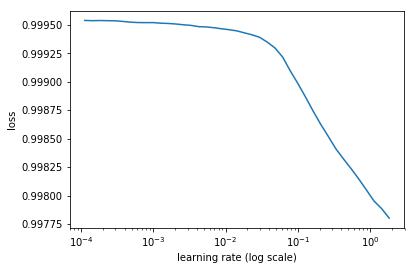

In [44]:
learn.lr_find()
learn.sched.plot()

In [45]:
lr=1e-2
wd=1e-5

lrs = np.array([lr/200,lr/20,lr])/2

In [46]:
learn.fit(lr,1,wds=wd,cycle_len=30,use_clr_beta=(20,10,0.95,0.85))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.999288   0.999497   0.399845   0.262507   0.130856   0.034259   0.471532  
    1      0.998424   0.996423   0.559596   0.168226   0.616442   0.670308   0.607476  
    2      0.996102   0.994016   0.58884    0.305015   0.583846   0.747472   0.555686  
    3      0.994867   0.993679   0.811635   0.69387    0.443259   0.81864    0.398787  
    4      0.994227   0.99302    0.863362   0.747112   0.606626   0.713761   0.585744  
    5      0.99382    0.99324    0.917773   0.886972   0.484554   0.801982   0.441552  
    6      0.99364    0.992604   0.937442   0.923153   0.608741   0.720367   0.588655  
    7      0.993543   0.992546   0.931122   0.905828   0.616386   0.753729   0.59237   
    8      0.993532   0.992785   0.932191   0.866329   0.594473   0.720422   0.572958  
    9      0.993497   0.992525   0.944002   0.944083   0.590173   0.771297   0.558278  
    10     0.993523   0.99264    0.936166   0.942065 

[array([0.99171]),
 0.9679697895050049,
 0.9603672290251092,
 0.754177516130979,
 0.7947377498867944,
 0.7456234546800813]

In [47]:
learn.save(f'128urn-{S_PREFIX}-tmp')

In [ ]:
learn.load(f'128urn-{S_PREFIX}-tmp')

In [48]:
learn.unfreeze()
learn.bn_freeze(True)

In [49]:
lr=1e-2
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [50]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.993125   0.99179    0.967287   0.961169   0.692954   0.856659   0.662742  
    1      0.993313   0.991931   0.957343   0.931359   0.779934   0.687821   0.808306  
    2      0.993167   0.991649   0.966279   0.95413    0.734599   0.828827   0.715127  
    3      0.993104   0.991626   0.968798   0.961632   0.75917    0.800359   0.750528  
    4      0.993067   0.991558   0.970495   0.961012   0.759078   0.81773    0.746606  
    5      0.993054   0.991596   0.96974    0.9584     0.748963   0.831933   0.731792  
    6      0.993027   0.991606   0.970321   0.966464   0.732343   0.848742   0.709303  
    7      0.993011   0.991547   0.972169   0.966849   0.75886    0.817972   0.746458  
    8      0.993007   0.991514   0.971801   0.966996   0.76903    0.812555   0.759887  
    9      0.993003   0.991537   0.97198    0.967081   0.764878   0.814894   0.754471  


[array([0.99154]),
 0.9719797515869141,
 0.9670810075927315,
 0.7648775820073409,
 0.814894096640206,
 0.7544709933734114]

In [51]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.992991   0.991522   0.971315   0.966899   0.774699   0.805817   0.768334  
    1      0.993009   0.991507   0.973001   0.968727   0.768189   0.817862   0.757783  
    2      0.993001   0.991503   0.972916   0.968286   0.770785   0.814759   0.761551  
    3      0.992996   0.991528   0.972659   0.969037   0.752433   0.840092   0.734359  
    4      0.992997   0.991486   0.97315    0.970242   0.776691   0.806818   0.770649  
    5      0.992989   0.991501   0.972775   0.968771   0.764637   0.827864   0.751311  
    6      0.99297    0.991533   0.97327    0.968443   0.772765   0.801161   0.767187  
    7      0.992956   0.991491   0.973598   0.970272   0.776179   0.810951   0.769092  
    8      0.992957   0.9915     0.973796   0.969113   0.766335   0.830458   0.75303   
    9      0.992969   0.991491   0.973858   0.96835    0.780189   0.805377   0.775277  


[array([0.99149]),
 0.9738581228256226,
 0.96835009557248,
 0.7801886448408979,
 0.8053772480156544,
 0.7752770291931729]

In [52]:
learn.save(f'128urn-{S_PREFIX}-0')

In [ ]:
learn.load(f'128urn-{S_PREFIX}-0')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x[:10])))

In [ ]:
# py = np.argmax(py,1)

In [ ]:
show_img(denorm(x[0]))

In [ ]:
py.shape

In [ ]:
show_img(py[0][0]>0.5);

In [ ]:
show_img(py[0][1]>0.5);

In [ ]:
show_img(y[0][1]);

## 256x256

In [53]:
ext = '-300'
sz=192
bs=64
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:7280, y:7280
All x:7280


In [54]:
lr=1e-2
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [55]:
import gc
gc.collect()

0

In [56]:
learn = get_learner(md)

In [57]:
learn.load(f'128urn-{S_PREFIX}-0')

In [58]:
learn.freeze_to(1)

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
learn.load(f'128urn-{S_PREFIX}-0')

In [59]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.986187   0.98578    0.958141   0.936369   0.698935   0.830589   0.675401  
    1      0.986116   0.989806   0.942021   0.943621   0.705296   0.364699   0.923139  
    2      0.986032   0.985097   0.96516    0.971153   0.756008   0.875643   0.733164  
    3      0.986004   0.984988   0.96411    0.972174   0.786146   0.852674   0.773058  
    4      0.98598    0.985205   0.964709   0.966278   0.753945   0.860285   0.733025  
    5      0.985832   0.9848     0.9728     0.970621   0.816443   0.842319   0.811313  
    6      0.985734   0.984708   0.97243    0.972756   0.819917   0.848734   0.814103  
    7      0.985683   0.984749   0.974943   0.965872   0.817183   0.846115   0.811084  
    8      0.985675   0.984712   0.974099   0.97226    0.799259   0.884337   0.781651  
    9      0.985613   0.9847     0.974779   0.97259    0.818061   0.85169    0.811396  


[array([0.9847]),
 0.974778745174408,
 0.9725898528445943,
 0.8180609783868552,
 0.8516898574783899,
 0.8113964502107627]

In [60]:
learn.save(f'256urn-{S_PREFIX}-tmp')

In [ ]:
learn.load(f'256urn-{S_PREFIX}-tmp')

In [61]:
learn.unfreeze()
learn.bn_freeze(True)

In [62]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.985558   0.984658   0.974797   0.971624   0.811044   0.870482   0.798908  
    1      0.985537   0.984574   0.977511   0.975512   0.826419   0.85981    0.819674  
    2      0.985517   0.984566   0.976832   0.979327   0.823831   0.865891   0.814945  
    3      0.985494   0.984608   0.977486   0.980511   0.810125   0.881422   0.795117  
    4      0.9855     0.984567   0.978493   0.979339   0.811333   0.887417   0.795362  
    5      0.985469   0.984549   0.977046   0.981497   0.823441   0.870452   0.813526  
    6      0.985462   0.984511   0.9795     0.981356   0.823173   0.877245   0.811615  
    7      0.985446   0.984498   0.979357   0.981134   0.826928   0.872638   0.817205  


[array([0.9845]),
 0.9793570685386658,
 0.9811342329197096,
 0.8269278765731137,
 0.8726375300744077,
 0.817205284678553]

In [ ]:
learn.fit(lrs/8,1,wds=wd, cycle_len=8,use_clr=(20,4))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.98545    0.984509   0.978876   0.981303   0.821434   0.881175   0.808745  
    1      0.985442   0.984498   0.978927   0.982552   0.819894   0.885342   0.806051  
    2      0.985463   0.984477   0.979115   0.981207   0.830218   0.871172   0.821502  
    3      0.985426   0.984477   0.980085   0.980525   0.827304   0.874918   0.817092  
 73%|███████▎  | 83/114 [00:20<00:07,  4.06it/s, loss=0.986]

In [63]:
learn.save(f'256urn-{S_PREFIX}')

In [ ]:
learn.load(f'256urn-{S_PREFIX}')

In [ ]:
x,y = next(iter(md.trn_dl))

In [ ]:
x.shape

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x[:8])))

In [ ]:
plt.imshow(denorm(x[0]))

In [ ]:
py.shape

In [ ]:
show_img(py[0][0]>0);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[-1]);

### No Crop

In [35]:
ext = '-300'
sz=192
bs=32
md = torch_loader(ext, PATH, bs, sz, workers, False, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:7280, y:7280
All x:7280


In [36]:
learn = get_learner(md)

In [37]:
learn.load(f'256urn-{S_PREFIX}')

In [38]:
learn.unfreeze()
learn.bn_freeze(True)

In [39]:
lr=1e-3
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [40]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.970422   0.971185   0.976941   0.982594   0.815441   0.885407   0.800988  
    1      0.971573   0.972402   0.971563   0.974436   0.759457   0.829902   0.748428  
    2      0.970904   0.971734   0.973749   0.976915   0.809631   0.827678   0.807785  
    3      0.970776   0.971961   0.969632   0.975212   0.803569   0.819174   0.802315  
    4      0.970076   0.971008   0.980451   0.979927   0.839677   0.862076   0.835832  
    5      0.96979    0.970664   0.984466   0.986329   0.845294   0.887507   0.836531  
    6      0.969818   0.970703   0.984266   0.987659   0.849734   0.875608   0.844777  
    7      0.969618   0.970574   0.984983   0.987157   0.848091   0.893403   0.838714  
    8      0.969524   0.970427   0.985935   0.987727   0.858364   0.891813   0.851389  
    9      0.969498   0.970465   0.985602   0.98814    0.852071   0.897514   0.842462  



[array([0.97047]),
 0.9856018543243408,
 0.9881401196312213,
 0.8520705374250199,
 0.8975137227798956,
 0.8424620217108175]

In [41]:
learn.save(f'256urn-{S_PREFIX}-nocrop')

## 512x512

In [42]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=384
bs=16
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

learn = get_learner(md)

Val Labels: 400
Val x:400, y:400
Trn x:7280, y:7280
All x:7280


In [ ]:
learn.lr_find()
learn.sched.plot()

In [43]:
# learn.load(f'256urn-{S_PREFIX}')
learn.load(f'256urn-{S_PREFIX}-nocrop')

In [44]:
learn.freeze_to(1)

In [45]:
lr=1e-3
wd=5e-7

In [46]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(10,4))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.942377   0.945089   0.967094   0.964784   0.805919   0.877533   0.792961  
    1      0.941573   0.944311   0.97769    0.979317   0.801943   0.917385   0.77981   
    2      0.941442   0.944034   0.979326   0.97712    0.822591   0.896145   0.808611  
    3      0.941097   0.943292   0.982642   0.982901   0.83745    0.9082     0.824258  



[array([0.94329]),
 0.982642080783844,
 0.9829009474289004,
 0.8374496919749772,
 0.9081999636313693,
 0.8242578587706353]

In [48]:
learn.fit(lr/4,1, wds=wd, cycle_len=4,use_clr=(10,4))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.941036   0.943307   0.98139    0.983097   0.839259   0.907525   0.82646   
    1      0.940936   0.943181   0.982646   0.984342   0.84004    0.912263   0.826111  
    2      0.941111   0.94328    0.982167   0.983823   0.830967   0.920997   0.813549  
    3      0.941052   0.943116   0.982293   0.983336   0.837235   0.919507   0.821486  



[array([0.94312]),
 0.9822927784919738,
 0.9833363337545227,
 0.8372347269798271,
 0.9195067442498425,
 0.8214864786810133]

In [47]:
learn.save(f'600urn-{S_PREFIX}-tmp')

In [ ]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [49]:
learn.unfreeze()
learn.bn_freeze(True)

In [50]:
lrs = np.array([lr/200,lr/20,lr])/2

In [51]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.94094    0.942948   0.982983   0.981975   0.848563   0.910114   0.83718   
    1      0.940967   0.942983   0.983187   0.982573   0.845727   0.912575   0.833104  
    2      0.940849   0.942916   0.983328   0.981925   0.850299   0.908424   0.839571  
    3      0.940709   0.942942   0.983294   0.982793   0.84754    0.911396   0.83557   



[array([0.94294]),
 0.9832943606376648,
 0.982792779916692,
 0.8475398177588171,
 0.9113964198193709,
 0.835569943699953]

In [53]:
learn.fit(lrs/40,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.940934   0.942983   0.983314   0.982622   0.84338    0.915751   0.829608  
    1      0.940951   0.942944   0.983334   0.983257   0.847238   0.911929   0.835093  
    2      0.940896   0.942956   0.98338    0.983061   0.846001   0.913109   0.833343  
    3      0.940855   0.942941   0.98341    0.98303    0.847235   0.912171   0.83503   



[array([0.94294]),
 0.9834097266197205,
 0.9830300811783045,
 0.8472350754900624,
 0.9121714898365816,
 0.8350304787580956]

In [52]:
learn.save(f'600urn-{S_PREFIX}')

In [ ]:
learn.sched.plot_loss()

### No Crop

In [61]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=384
bs=16
md = torch_loader(ext, PATH, bs, sz, workers, False, pseudo_label, val_folder)

learn = get_learner(md)

Val Labels: 400
Val x:400, y:400
Trn x:7280, y:7280
All x:7280


In [62]:
import gc
gc.collect()

0

In [63]:
learn.load(f'600urn-{S_PREFIX}')
# learn.load(f'256urn-{S_PREFIX}-nocrop')
# learn.load('600urn-19-weights-26-r8')

In [64]:
lr=5e-4
wd=5e-7
lrs = np.array([lr/200,lr/20,lr])/2

In [65]:
learn.unfreeze()
learn.bn_freeze(True)

In [66]:
learn.fit(lrs,1, wds=wd,cycle_len=4,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.940271   0.942751   0.984548   0.984653   0.856603   0.906216   0.847974  
    1      0.940178   0.942773   0.984671   0.987009   0.862749   0.895282   0.858307  
    2      0.94011    0.94264    0.984967   0.987769   0.859359   0.907494   0.851022  
    3      0.940022   0.94259    0.985404   0.987466   0.865464   0.900354   0.860287  


[array([0.94259]),
 0.9854037475585937,
 0.9874663763065098,
 0.865463624057202,
 0.9003540434637146,
 0.8602869544977563]

In [67]:
learn.save(f'600urn-{S_PREFIX}-nocrop-tmp')

In [ ]:
learn.load(f'600urn-{S_PREFIX}-nocrop-tmp')

In [68]:
learn.unfreeze()
learn.bn_freeze(True)

In [69]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.940066   0.942589   0.98557    0.98708    0.865392   0.900353   0.860169  
    1      0.940053   0.942577   0.985507   0.987073   0.867611   0.897821   0.863507  
    2      0.940102   0.942575   0.985458   0.987438   0.865488   0.901034   0.860117  
    3      0.94001    0.942582   0.985493   0.987442   0.866754   0.898738   0.862231  


[array([0.94258]),
 0.9854930067062377,
 0.9874421448204224,
 0.8667542223445959,
 0.898738497285085,
 0.8622307013890407]

In [70]:
learn.save(f'600urn-{S_PREFIX}-nocrop-tmp-2')

In [71]:
learn.fit(lrs/100,1, wds=wd,cycle_len=4,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.940096   0.942582   0.985489   0.987466   0.866337   0.899386   0.861562  
    1      0.940001   0.942581   0.985533   0.987385   0.86695    0.898402   0.862561  
    2      0.940017   0.942582   0.985503   0.987451   0.866416   0.899227   0.86171   
    3      0.940032   0.942581   0.985509   0.987442   0.86662    0.898961   0.862023  


[array([0.94258]),
 0.9855089330673218,
 0.9874423556504216,
 0.8666203238401974,
 0.8989611525088361,
 0.8620228927135984]

In [73]:
learn.fit(lrs/50,1, wds=wd,cycle_len=4,use_clr_beta=(20,20,0.95,0.85))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.939993   0.942583   0.985509   0.987489   0.866713   0.898714   0.862205  
    1      0.940025   0.942583   0.985534   0.987447   0.865228   0.90077    0.85988   
    2      0.94001    0.942578   0.98556    0.98743    0.866987   0.898538   0.862586  
    3      0.940091   0.942578   0.98555    0.987454   0.867132   0.898293   0.862822  


[array([0.94258]),
 0.9855499458312988,
 0.9874541679354227,
 0.8671319349771137,
 0.898293211713129,
 0.8628218196110179]

In [72]:
learn.save(f'600urn-{S_PREFIX}-nocrop')

### Visualize Results

In [37]:
learn.load(f'600urn-36-resnet-softmax-nocrop-tmp')

In [57]:
val_it = iter(md.val_dl)

In [58]:
x,y = next(val_it)

In [40]:
x[1].mean()

-0.0740935039341068

In [41]:
x.shape

torch.Size([6, 3, 384, 800])

In [78]:
type(x)

torch.FloatTensor

In [79]:
res = learn.model(V(x).cuda())

In [80]:
mx,idx = torch.max(res,1)
idx = idx.cpu().data.numpy()

In [81]:
idx.shape

(6, 384, 800)

In [82]:
type(idx)

numpy.ndarray

In [83]:
i=0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


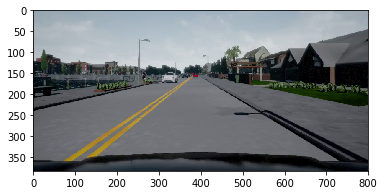

In [84]:
plt.imshow(denorm(x[i]))

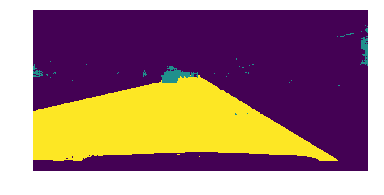

In [85]:
show_img(idx[i]);

In [63]:
idx[0].mean()

0.594267578125

In [ ]:
show_img(py[idx][1]);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[idx][0]);

## Save results

In [42]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [43]:
m = Unet34()

In [44]:
cuda_enabled = torch.cuda.is_available()
DATA_PATH = Path('../data/all')
model_path = str(DATA_PATH/'models/600urn-36-resnet-softmax-nocrop-tmp.h5')
# model_path = str(PATH/'models/600urn-19-weights-26-r9.h5')
if cuda_enabled:
    m = m.cuda()
    m.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage))
else:
    m.load_state_dict(torch.load(model_path))


In [45]:

# file = sys.argv[-1]

R_PATH = Path.cwd()
file = R_PATH/'test_video.mp4'
mismatched_idxs = []
student_output = R_PATH/'tester_data_crop'
ans_key = R_PATH/'results.json'

# R_PATH = Path('../data/lyft-answers')
# file = R_PATH/'test_video.mp4'
# ans_key = R_PATH/'results.json'
# mismatched_idxs = list(range(15,44)) + list(range(200,750))
# student_output = R_PATH/'tester_data_crop'

if file == 'demo.py':
  print ("Error loading video")
  quit

# Define encoder function
def encode(array):
	pil_img = Image.fromarray(array)
	buff = BytesIO()
	pil_img.save(buff, format="PNG")
	return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)


In [46]:
imagenet_stats = torch.cuda.FloatTensor([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
def normalize(x):
    if x.mean() > 1:
        x.div_(255.0)
    m,s = imagenet_stats
#     return TVF.normalize(x, m, s)
#     print(x.shape)
    x.sub_(m.view(-1, 1, 1))
    x.div_(s.view(-1, 1, 1))
    return x

def crop_bg(x):
    # Original
    h = x.shape[2]
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    return x[:,:,top:bot,:]

def pad(x):
#     print(x.shape)
    # Original
    b,c,w,h = x.shape
#     print(x.shape)
    if h%32 == 0:
        return x, 0
    pad_right=32-h%32
    if pad_right:
        x = F.pad(x, (0,pad_right,0,0), 'constant', 0)
    return x, pad_right
    
def undo(idx):
    idx
    idx = F.pad(idx, (0,0,226,54), "constant", 0)

def preprocess(video):
#     f1 = video[:,200:520,:,:]
    f1 = np.rollaxis(video, 3, 1)
    f1 = torch.from_numpy(f1).float().cuda()
    f1 = crop_bg(f1)
    f1 = normalize(f1)
    return f1.contiguous()

In [47]:
video_p = preprocess(video)
if len(video_p) == 31:
    video_p = torch.cat((video_p[:15], video_p[16:]))

In [48]:
import gc
gc.collect()

0

In [49]:
results = []
raw_results = []
raw_frames = []
answer_key = {}
bs = 4

        
for i in range(0,video_p.shape[0],bs):
    x = video_p[i:i+bs]
    
#     x = torch.from_numpy(f1).contiguous().float()
#     if cuda_enabled:
#         x = x.cuda()
        
    x,p = pad(x)
    preds = m(torch.autograd.Variable(x))
#     preds = F.sigmoid(preds)
    # Indexes
    mx,idx = torch.max(preds, 1)
    for i in idx:
        raw_frames.append(i.data.cpu().numpy())
    if p > 0:
        idx = idx[:,:,:-p]
    idx = F.pad(idx, (0,0,160,56), "constant", 0)
    frame_idx = 1+i
    for frame in idx:
        frame = frame.data.cpu().numpy()
#         results.append(frame)
        raw_frames.append(frame)
        binary_car_result = (frame==1).astype('uint8')
        binary_road_result = (frame==2).astype('uint8')
#         answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
        raw_results.append([binary_car_result, binary_road_result])
        results.append([encode(binary_car_result), encode(binary_road_result)])
        frame_idx+=1
    
    # Preds
#     if p > 0:
#         preds = preds[:,:,:,:-p]
#     preds = F.pad(preds, (0,0,160,56,0,0), "constant", 0)
#     frame_idx = 1+i
#     for frame in preds:
#         frame = frame.data.cpu().float().numpy()
#         f_results.append(frame)
#         binary_car_result = (frame[0]>0.5).astype('uint8')
#         binary_road_result = (frame[1]>0.5).astype('uint8')
#         answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
#         raw_results.append([binary_car_result, binary_road_result])
#         results.append([encode(binary_car_result), encode(binary_road_result)])
#         frame_idx+=1

In [50]:
type(video_p.cpu())

torch.FloatTensor

In [51]:
type(x)

torch.cuda.FloatTensor

In [52]:
video_p[0,:,50:200,700:].sum(), x[0,:,50:200,700:].cuda().sum()

(-40010.24609375, -75920.484375)

In [53]:
video_p[0].shape

torch.Size([3, 384, 800])

In [61]:
x[0].shape

torch.Size([3, 384, 800])

In [62]:
x[0][2][200].cuda().sum()

-327.111083984375

In [60]:
(video_p[0] - x[0].cuda()).sum()

0.07669202238321304

In [59]:
md.val_ds.fnames

array(['../data/val/CameraRGB/0.png', '../data/val/CameraRGB/1.png', '../data/val/CameraRGB/10.png',
       '../data/val/CameraRGB/11.png', '../data/val/CameraRGB/12.png', '../data/val/CameraRGB/13.png',
       '../data/val/CameraRGB/14.png', '../data/val/CameraRGB/15.png', '../data/val/CameraRGB/16.png',
       '../data/val/CameraRGB/17.png', '../data/val/CameraRGB/18.png', '../data/val/CameraRGB/19.png',
       '../data/val/CameraRGB/2.png', '../data/val/CameraRGB/20.png', '../data/val/CameraRGB/21.png',
       '../data/val/CameraRGB/22.png', '../data/val/CameraRGB/23.png', '../data/val/CameraRGB/24.png',
       '../data/val/CameraRGB/25.png', '../data/val/CameraRGB/26.png', '../data/val/CameraRGB/27.png',
       '../data/val/CameraRGB/28.png', '../data/val/CameraRGB/29.png', '../data/val/CameraRGB/3.png',
       '../data/val/CameraRGB/4.png', '../data/val/CameraRGB/5.png', '../data/val/CameraRGB/6.png',
       '../data/val/CameraRGB/7.png', '../data/val/CameraRGB/8.png', '../data/va

In [63]:
show_idx = 0

In [64]:
video_p[show_idx].mean(), x[show_idx].mean()

(-0.06563019007444382, -0.06563026601495242)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


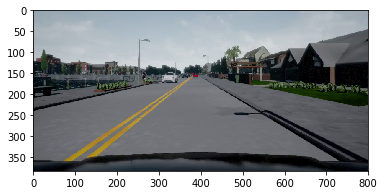

In [65]:
plt.imshow(denorm(x[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


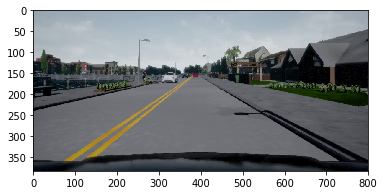

In [66]:
plt.imshow(denorm(video_p[show_idx]))

In [73]:
learn_res = learn.model(V(video_p[0:4]))

RuntimeError: bool value of Variable objects containing non-empty torch.cuda.FloatTensor is ambiguous

In [68]:
_,learn_idx = torch.max(learn_res,1)
learn_idx = learn_idx.cpu().data.numpy()

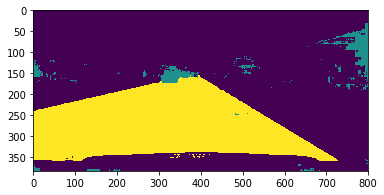

In [69]:
plt.imshow(learn_idx[show_idx])

In [70]:
learn_dl_res = learn.model(V(x[0:4].cuda()))

In [71]:
_,learn_dl_idx = torch.max(learn_dl_res,1)
learn_dl_idx = learn_dl_idx.cpu().data.numpy()

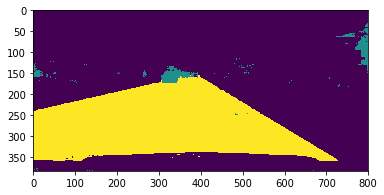

In [72]:
plt.imshow(learn_dl_idx[show_idx])

In [74]:
m_dl_res = m(V(x.cuda()))

In [75]:
_,m_dl_idx = torch.max(m_dl_res,1)
m_dl_idx = m_dl_idx.cpu().data.numpy()

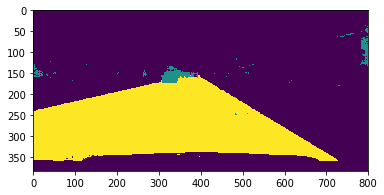

In [76]:
plt.imshow(m_dl_idx[show_idx])

In [84]:
m.train()

Unet34(
  (rn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pa

In [85]:
m_res = m(V(video_p[0:4]))

In [86]:
_,m_idx = torch.max(m_res,1)
m_idx = m_idx.cpu().data.numpy()

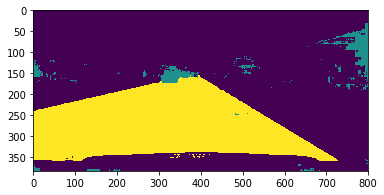

In [87]:
plt.imshow(m_idx[show_idx])

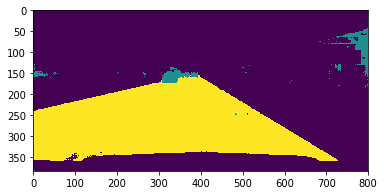

In [83]:
plt.imshow(m_idx[show_idx])

In [206]:
a = video_p[:6]

In [207]:
b = x[:6].cuda()

In [208]:

m_res2 = m(V(a))

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [ ]:
m_res2.shape

In [209]:
_,m_idx2 = torch.max(m_res2,1)
m_idx2 = m_idx2.cpu().data.numpy()

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generated/../THCTensorMathReduce.cuh:595

In [210]:
m_idx2.shape

(10, 384, 800)

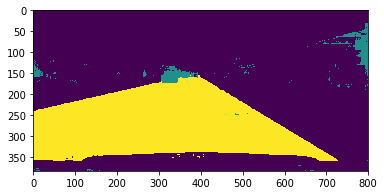

In [211]:
plt.imshow(m_idx2[0])

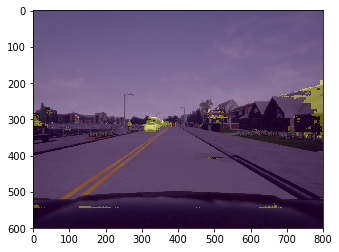

In [160]:
idx = 0
plt.figure()
plt.imshow(video[idx])
plt.imshow((raw_results[idx][0]==1).data, alpha=.4)
plt.show()

In [ ]:
for i in range(1, len(results)//10*10+1):
    s_idx = i if i in mismatched_idxs else i-1
#     s_idx = i-1
    answer_key[i] = results[s_idx]

In [ ]:
# Print output in proper json format
tester_data = json.dumps(answer_key)
with open(student_output, 'w') as f:
    f.write(tester_data)
# print(json.dumps(answer_key))

### Decoding car

In [ ]:
PATH

In [35]:
def decode(packet):
	img = base64.b64decode(packet)
	filename = R_PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open(ans_key) as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

# Load student data
with open(student_output) as student_data:
	student_ans_data = json.loads(student_data.read())
	student_data.close()

frames_processed = 0

Car_TP = 1 # True Positives
Car_FP = 1 # Flase Positives
Car_TN = 1 # True Negatives
Car_FN = 1 # True Negatives

Road_TP = 1 # True Positives
Road_FP = 1 # Flase Positives
Road_TN = 1 # True Negatives
Road_FN = 1 # True Negatives

for frame in range(1,len(ans_data.keys())+1):
    if frame%3 == 0: continue
    truth_data_car =  decode(ans_data[str(frame)][0])
    truth_data_road =  decode(ans_data[str(frame)][1])
    student_data_car = decode(student_ans_data[str(frame)][0])
    student_data_road = decode(student_ans_data[str(frame)][1])
#     student_data_car = results[frame-1][0]
#     student_data_road = results[frame-1][1]
#     student_data_car = f_results[frame-1][0]
#     student_data_road = f_results[frame-1][1]
#     print(np.mean(student_data_road == 1))
#     print(np.mean(student_data_road_f == 1))
#     pdb.set_trace()

    Car_TP += np.sum(np.logical_and(student_data_car == 1, truth_data_car == 1))
    Car_FP += np.sum(np.logical_and(student_data_car == 1, truth_data_car == 0))
    Car_TN += np.sum(np.logical_and(student_data_car == 0, truth_data_car == 0))
    Car_FN += np.sum(np.logical_and(student_data_car == 0, truth_data_car == 1))

    Road_TP += np.sum(np.logical_and(student_data_road == 1, truth_data_road == 1))
    Road_FP += np.sum(np.logical_and(student_data_road == 1, truth_data_road == 0))
    Road_TN += np.sum(np.logical_and(student_data_road == 0, truth_data_road == 0))
    Road_FN += np.sum(np.logical_and(student_data_road == 0, truth_data_road == 1))

    frames_processed+=1


# Generate results
Car_precision = Car_TP/(Car_TP+Car_FP)/1.0
Car_recall = Car_TP/(Car_TP+Car_FN)/1.0
Car_beta = 2
Car_F = (1+Car_beta**2) * ((Car_precision*Car_recall)/(Car_beta**2 * Car_precision + Car_recall))
Road_precision = Road_TP/(Road_TP+Road_FP)/1.0
Road_recall = Road_TP/(Road_TP+Road_FN)/1.0
Road_beta = 0.5
Road_F = (1+Road_beta**2) * ((Road_precision*Road_recall)/(Road_beta**2 * Road_precision + Road_recall))

print ("Car F score: %05.3f  | Car Precision: %05.3f  | Car Recall: %05.3f  |\n\
Road F score: %05.3f | Road Precision: %05.3f | Road Recall: %05.3f | \n\
Averaged F score: %05.3f" %(Car_F,Car_precision,Car_recall,Road_F,Road_precision,Road_recall,((Car_F+Road_F)/2.0)))

NameError: name 'ans_key' is not defined

In [36]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [ ]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

In [ ]:
plot_ans(10)

In [ ]:
ans = decode(ans_data['1'][0])

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()